In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="rdbench"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    # for ext in ('png', 'eps'):
    #     fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 


In [2]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [3]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    ("rdbench-pmembb/2024.01.29-15.40.22-nosync", {"storageSystem": "PMEMBB"}),
    ("rdbench-beeond/2024.02.19-16.31.53-default", {}),
    ("rdbench-lustre/2024.02.21-14.28.22-default", {}),
    ("rdbench-chfs/2024.02.22-23.25.04-default", {}),
    ("rdbench-chfs/2024.02.22-23.25.54-default", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        for job_params_file in job_dir.glob("job_params_*.json"):
            try:
                runid = get_runid(job_params_file)
                job_params = json.loads(job_params_file.read_text())
                rdbench_result_file = job_dir / f"rdbench_stdout_{runid}.json"
                rdbench_result = json.loads(rdbench_result_file.read_text())
                pmembb_time = extract_hook_pmembb_time_max(job_dir / f"rdbench_stderr_{runid}.txt")
                src.append({
                    **default_metadata,
                    **metadata,
                    **job_start,
                    **job_nodelist,
                    **job_params,
                    **pmembb_time,
                    **rdbench_result,
                    "runid": runid,
                })
            except FileNotFoundError as e:
                print(e)
            except Exception as e:
                print(f'{job_dir}/{job_params_file}, {e}')

# df_src = (
#     pd.DataFrame(src)
#     .assign(odirect=lambda x: x["Command line"].str.contains("--posix.odirect"))
#     .assign(strided=lambda x: x["summary_transferSize"] == x["summary_blockSize"])
#     .rename({
#         "summary_bwMaxMIB": "bw",
#         "summary_MeanTime": "time",
#         "summary_segmentCount": "segmentCount",
#         "summary_blockSize": "blockSize",
#         "summary_transferSize": "transferSize",
#         "summary_operation": "operation",
#         "Parameters_filePerProc": "fpp",
#         "Parameters_reorderTasks": "reorder",
#         "summary_API": "api",
#         "result_access": "access",
#         "result_bwMiB": "bwMiB",
#         "result_openTime": "openTime",
#         "result_wrRdTime": "wrRdTime",
#         "result_closeTime": "closeTime",
#         "result_totalTime": "totalTime",
#     }, axis=1)
#     .astype({"fpp": bool, "reorder": bool,})
#     .assign(bwGB=lambda x: x["bwMiB"] * 2**20 / 10**9)
# )
# df_src["label"] = np.select([
#     (df_src["access"] == "write"),
#     (df_src["access"] == "read") & (df_src["reorder"] == True),
#     (df_src["access"] == "read") & (df_src["reorder"] == False),
# ], ["Write", "Read (remote)", "Read (local)"])


df_src = (
    pd.DataFrame(src)
    .drop(columns=[
        'phaseDurationsSec',
    ])
    .assign(bwGB=lambda x: x['writeBandwidthByte'] / 1000**3)
)

df_src.head()


,storageSystem,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,...,chfs_chunk_size,chfs_log_priority,chfs_nthreads,chfs_niothreads,chfs_rdma_thresh,chfs_async_access,chfs_lookup_local,chfs_version,fi_universe_size,bwGB
0,PMEMBB,2024.01.29-15.40.22,"[bnode030, bnode031, bnode032, bnode040]",4,48,192,168085.nqsv,0,/dev/dax0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.712020
1,PMEMBB,2024.01.29-15.40.22,"[bnode001, bnode002, bnode003, bnode004, bnode...",64,48,3072,168110.nqsv,0,/dev/dax0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1168.441238
2,PMEMBB,2024.01.29-15.40.22,"[bnode001, bnode002, bnode003, bnode004, bnode...",49,48,2352,168107.nqsv,0,/dev/dax0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,926.461873
3,PMEMBB,2024.01.29-15.40.22,"[bnode001, bnode002, bnode003, bnode004, bnode...",49,48,2352,168105.nqsv,0,/dev/dax0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,861.852578
4,PMEMBB,2024.01.29-15.40.22,"[bnode022, bnode023, bnode024, bnode025, bnode...",36,48,1728,168101.nqsv,0,/dev/dax0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,722.689719


In [4]:
df = df_src

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "storageSystem",
        "spack_env_name",
        "nnodes",
        "ppn",
        "bwGB",
    ]]
    # .head()
)


,storageSystem,spack_env_name,nnodes,ppn,bwGB
0,PMEMBB,mpiio-pmembb-deferred-open,4,48,87.712020
1,PMEMBB,mpiio-pmembb,64,48,1168.441238
2,PMEMBB,mpiio-pmembb-deferred-open,49,48,926.461873
3,PMEMBB,mpiio-pmembb-deferred-open,49,48,861.852578
4,PMEMBB,mpiio-pmembb-deferred-open,36,48,722.689719
5,PMEMBB,mpiio-pmembb-deferred-open,36,48,706.817777
6,PMEMBB,mpiio-pmembb-deferred-open,4,48,92.500124
7,PMEMBB,mpiio-pmembb,36,48,731.825098
8,PMEMBB,mpiio-pmembb,25,48,515.568929
9,PMEMBB,mpiio-pmembb,4,48,87.633009


<Axes: xlabel='storageSystem,spack_env_name,nnodes,ppn'>

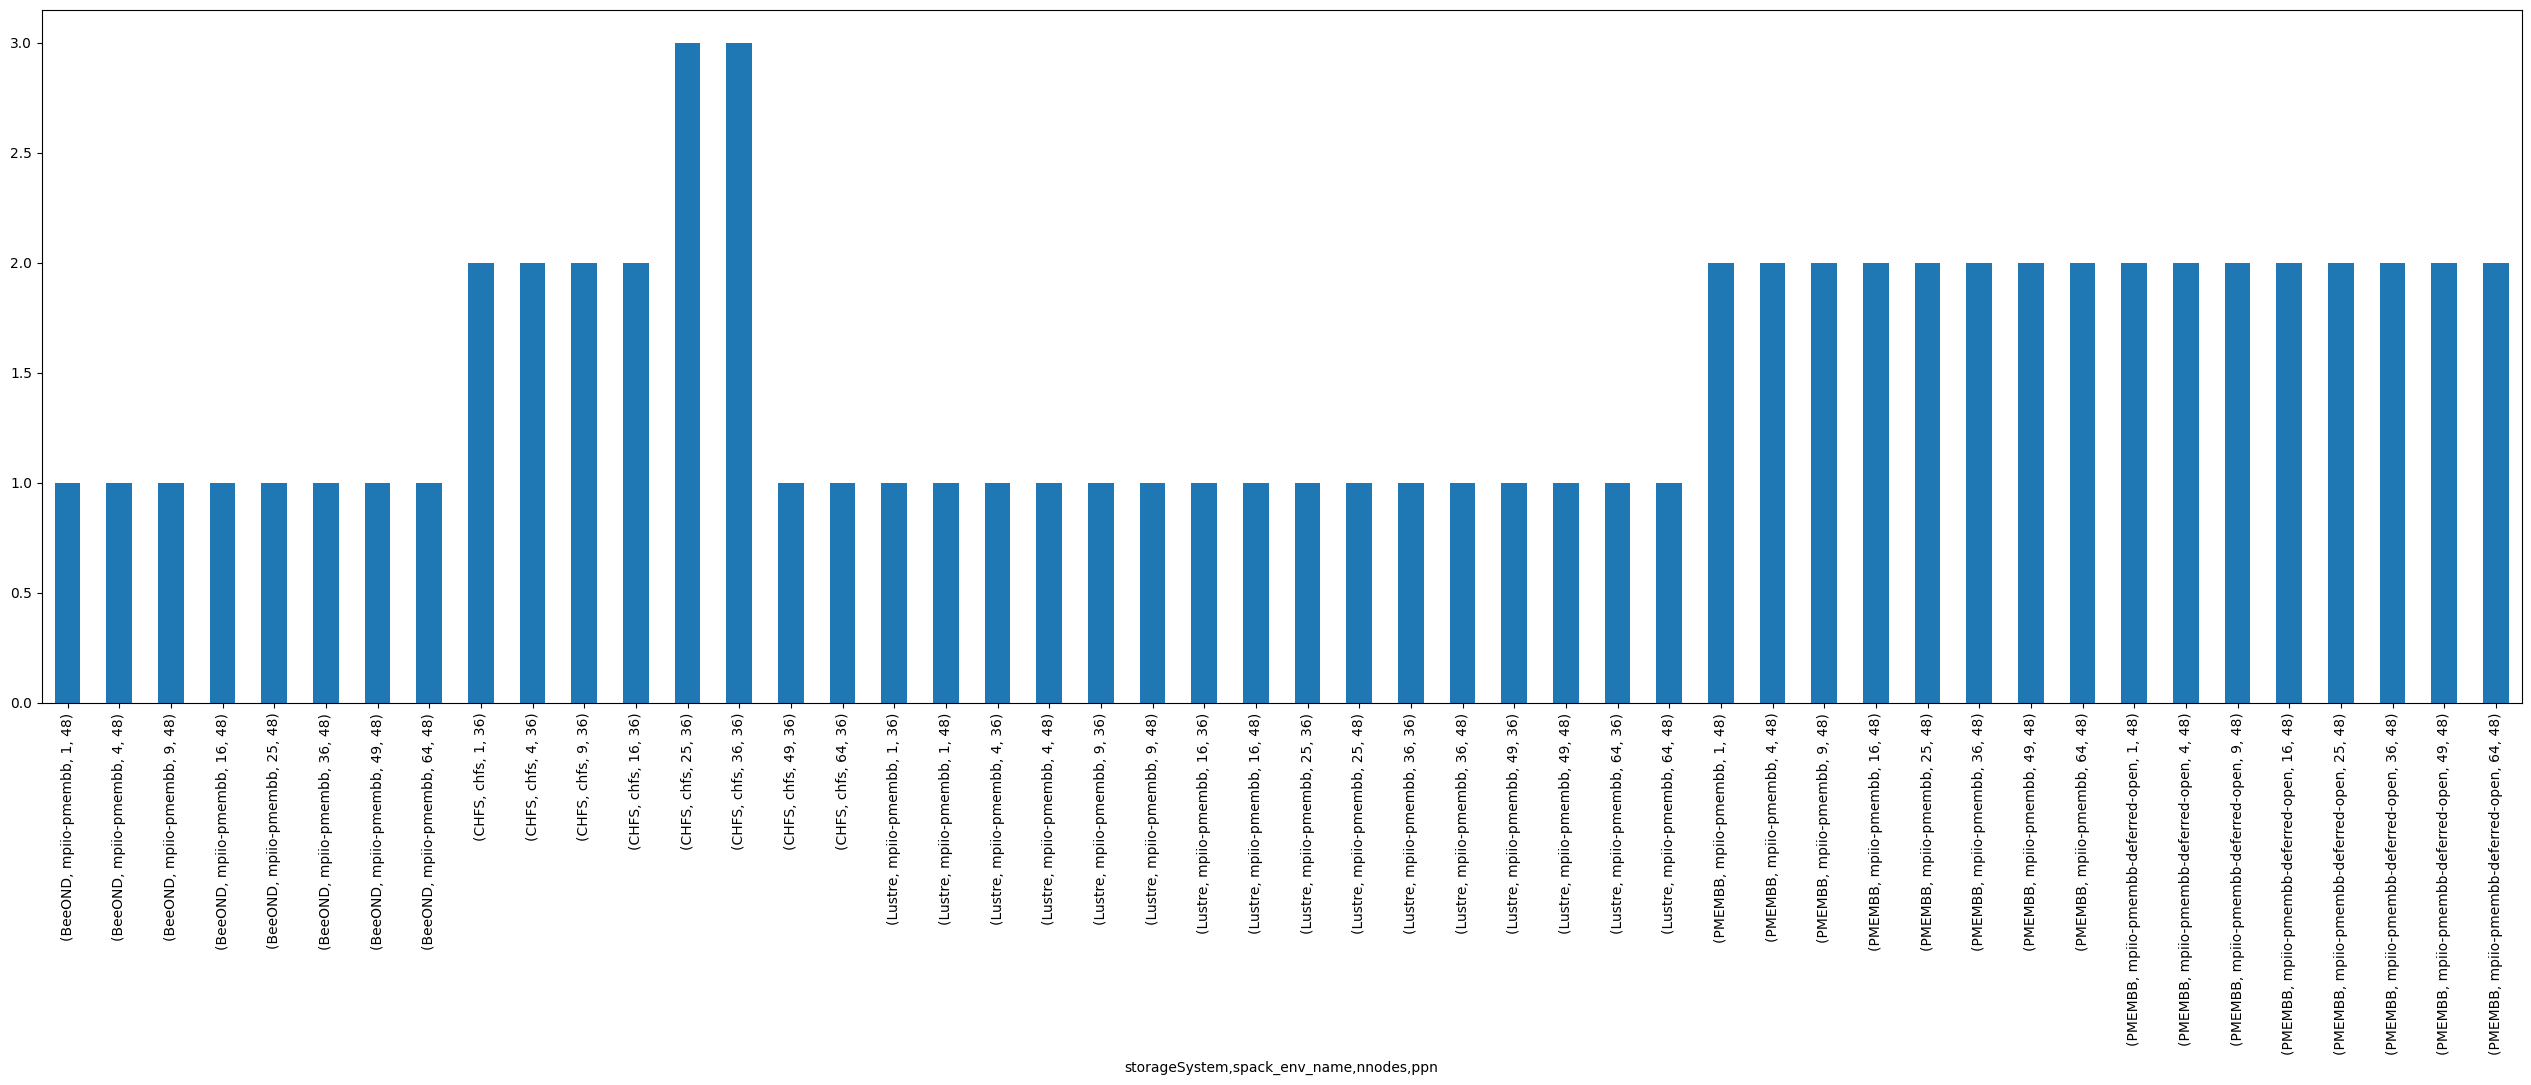

In [5]:
df = df_src
same_setting_columns = [
    "storageSystem",
    "spack_env_name",
    "nnodes",
    "ppn",
    # "lustre_stripe_count",
]
same_setting_grouper = df.groupby(same_setting_columns)

(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


,storageSystem,spack_env_name,nnodes,ppn,bwGB
0,BeeOND,mpiio-pmembb,1,48,0.963805
1,BeeOND,mpiio-pmembb,4,48,3.361569
2,BeeOND,mpiio-pmembb,9,48,6.434098
3,BeeOND,mpiio-pmembb,16,48,9.892540
4,BeeOND,mpiio-pmembb,25,48,13.136383
5,BeeOND,mpiio-pmembb,36,48,15.177907
6,BeeOND,mpiio-pmembb,49,48,15.960174
7,BeeOND,mpiio-pmembb,64,48,15.758010
8,CHFS,chfs,1,36,3.830495
9,CHFS,chfs,4,36,15.696539


storageSystem,Lustre,BeeOND on PMEM,CHFS,PMEMBB
nnodes,,,,
1,2.070287,0.963805,3.830495,23.570439
4,5.235540,3.361569,15.696539,87.715552
9,7.462358,6.434098,33.952820,192.837172
16,7.073448,9.892540,55.194750,337.448248
25,6.636513,13.136383,78.459459,520.826046
36,6.218528,15.177907,91.853072,736.188194
49,3.243354,15.960174,103.107552,959.948339
64,7.869038,15.758010,143.041560,1221.952894


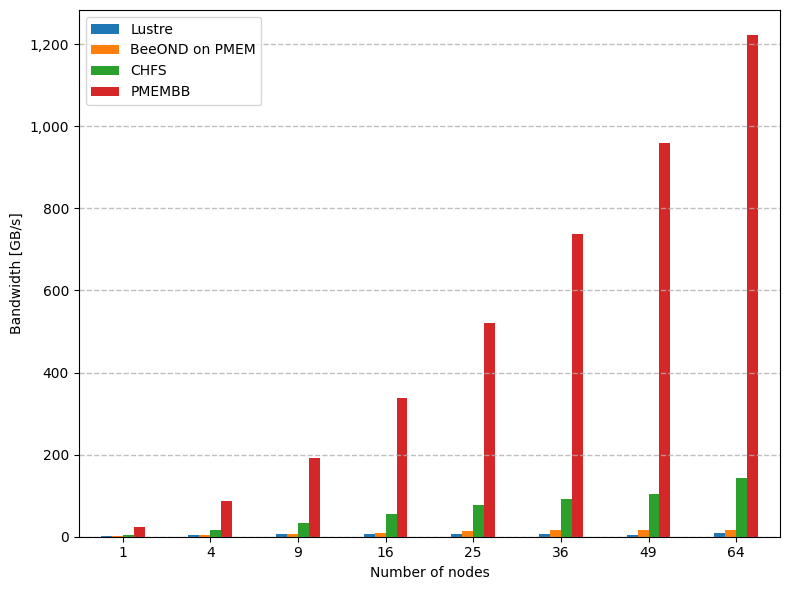

In [6]:
df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    # .query("lustre_stripe_count == 1")
    # .query("spack_env_name == 'mpiio-pmembb'")
    .query("spack_env_name != 'mpiio-pmembb-deferred-open'")
    .query("storageSystem == 'CHFS' or ppn == 48")
    # .query("not ('storageSystem' == 'Lustre' and 'ppn' != 48)")
)

display(df)

df_plot = df.pivot(index="nnodes", columns=["storageSystem", "ppn"], values=["bwGB"])
df_plot.columns = df_plot.columns.get_level_values(1)
df_plot = df_plot.loc[:, [
    "Lustre",
    "BeeOND",
    "CHFS",
    "PMEMBB",
]].rename({
    "BeeOND": "BeeOND on PMEM",
}, axis=1)

display(df_plot)


fig = plt.figure(figsize=(8, 6), dpi=100)
fig.patch.set_alpha(1)

ax = df_plot.plot(
    ax=fig.add_subplot(),
    kind="bar",
    # kind="line",
    # xlabel="Transfer size [B]",
    xlabel="Number of nodes",
    ylabel="Bandwidth [GB/s]",
    # style=".-",
    legend=True,
    rot=0,
)

# ax.set_title(f"RDBench")
# ax.set_xscale("log", base=2)
# ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
# handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
# ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

# legend_title = ax.get_legend().get_title().get_text()
# ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax.legend(title="")
plt.tight_layout()

fig.show()
plt.show()
save(fig, F"rdbench_write")
